In [78]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [79]:
from fastbook import *
from IPython.display import display,HTML

In [80]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

Till now, we have been looking at fastai api to get job done like TextDataLaders.from_folder etc.
There are low level APIs which offer some flexibility as well like DataBlock and also there are still low level APIs.

In [81]:
# in this api, y labels are obtained from the parent directory, independent data are obtained from folders trian and test
# splitting is done on the basis of folder name as well
path = untar_data(URLs.IMDB)
dls = DataBlock(blocks=(TextBlock.from_folder(path), CategoryBlock),get_y=parent_label, get_items=partial(get_text_files,folders=['train', 'test']),
               splitter=GrandparentSplitter(valid_name='test')).dataloaders(path)







Mid level API implementation - for dataloaders etc (uses a callback system).


In [82]:
# fastai API to get text files from the requested folders in the path
files = get_text_files(path,folders=['train','test'])
txts = L(o.open().read() for o in files[:2000]) # read the first 2000 files texts
         

In [83]:
txts[0]

'This is an oft-used line, but it really sums up this movie..."If this is the current state of gay cinema, then we\'re in real trouble". I saw this film at SIFF because of the high IMDb rating (7.6) and if there was ever a case of vote stacking on IMDb, then this is it. Just watch the number fall over the release weeks of the film.<br /><br />Easy plot...Boy finds out his high school ex (boyfriend) is getting married to a female friend of theirs so he goes back to his old hometown (still carrying a 10 year old torch) to see what happened.<br /><br />First off, I liked "Latter Days", the director\'s last feature, despite its cookie cutter characters and plot contrivances, but you\'re supposed to become a better director with each subsequent release. I don\'t know how you get horrible supporting performances out of so many TV veterans (Robert Foxworth, Joanna Cassidy, Tori Spelling), but somehow he managed to. The writing was Lifetime Network quality (way back when they were REALLY bad) 

tokenization of the txts

In [84]:
tok = Tokenizer.from_folder(path) # create a tokenization index for words in the path folder

In [85]:
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#419) ['xxbos','xxmaj','this','is','an','oft','-','used','line',','...]

Numericalization

In [86]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)

Transform is an object that behaves like function with optional methods like setup and decode to transform data from string to tokens and tokens to vocab(with setup) or vice versa(with decode).
The transform object works on tupes (input,target). so, if we want to perform transforms on X or Y, they have to be extracted and then performed operations.


In [87]:
tok((txts[0], txts[1]))

((#419) ['xxbos','xxmaj','this','is','an','oft','-','used','line',','...],
 (#334) ['xxbos','xxmaj','let','me','first','start','out','by','saying','1'...])

writing own transforms - A transform will be applied to a particular type if a matching type is provided, else it is applied to all types.

In [88]:
def f(x:int) : return x+1
tfm = Transform(f)


tfm(2),tfm(2.0)

(3, 2.0)

in python , a function is passed to another function using decorator. the code below is identical to the code above, where f was passed to transform as an argument.

In [89]:
@Transform
def f(x:int) : return x+1

f(2), f(2.0)

(3, 2.0)

To have setup() and decode(), we need to inherit from the Transform class

In [90]:
#example code 
class NormalizeMean(Transform):
    def setups(self,items) : self.mean = sum(items)/len(items)
    def encodes(self,x) : return x-self.mean
    def decodes(self,x) : return x+self.mean

while calling the methods of this class, we don't directly call setups, but setup, which does some work prior to calling setups. Also, calling constructor () will call encodes inside in the forward method in pytorch. also, decode() will call decodes.


In [91]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)

In [92]:
tfm.mean, y,z


(3.0, -1.0, 2.0)

Pipeline class is provided for packing all the transforms together into a single package


In [93]:
tfms = Pipeline([tok,num])


In [94]:
type(txts)

fastcore.foundation.L

In [95]:
t = tfms(txts[0]); t[:20]

TensorText([   2,    8,   20,   16,   54, 5679,   25,  386,  337,   11,   28,   17,   81, 3744,   74,   20,   26,   70,   22,   60])

In [96]:
tfms.decode(t)

'xxbos xxmaj this is an oft - used line , but it really sums up this movie … " if this is the current state of gay cinema , then we \'re in real trouble " . i saw this film at xxup xxunk because of the high imdb rating ( xxunk ) and if there was ever a case of vote xxunk on imdb , then this is it . xxmaj just watch the number fall over the release weeks of the film . \n\n xxmaj easy plot … boy finds out his high school ex ( boyfriend ) is getting married to a female friend of theirs so he goes back to his old xxunk ( still carrying a 10 year old torch ) to see what happened . \n\n xxmaj first off , i liked " latter xxmaj days " , the director \'s last feature , despite its cookie cutter characters and plot contrivances , but you \'re supposed to become a better director with each subsequent release . i do n\'t know how you get horrible supporting performances out of so many xxup tv veterans ( robert xxmaj xxunk , xxmaj joanna xxmaj cassidy , xxmaj tori xxmaj spelling ) , but somehow he

the decode function works as well, the setup method does not work as in Transform.   Pipeline combines together the transform functions. tfmdLists combines the pipeline with the raw inputs which may be in the form of files, rows in a dataframe.

In [97]:
tls = TfmdLists(files,[Tokenizer.from_folder(path), Numericalize])

the transformedList class calls the setup function for each transform first and then transforms the input successively to get the final network ready form.

In [98]:
t = tls[0] ; t[:20]


TensorText([    2,     8,    20,    16,    49, 11297,    24,   348,   369,    11,    31,    17,    85,  5609,    73,    20,    30,    76,    22,    63])

In [99]:
tls.decode(t[:20])

'xxbos xxmaj this is an oft - used line , but it really sums up this movie … " if'

TfmdLists can handle training and test arguments as well - hence the s after TfmdLists , using the split argument

In [100]:
len(files)

50000

In [101]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]

In [102]:
tls = TfmdLists(files,[Tokenizer.from_folder(path), Numericalize], splits = splits)

the valid and training set data can then be accessed through valid and train data members.

In [103]:
tls.valid[0][:20]

TensorText([  2,   8,   9,   8, 947,   8, 682,  26,   8,  65,  33,  86,  16,  65,  33,  98,  10,   8,  38,  85])

TfmdLists converts raw input (files) to a form which is suitable for use in neural networks, but there may be situations where two parallel transforms may be required - one for raw text as done above and one for classification - target labels. labels in this example may be obtained from parent folder name

In [104]:
type(files)


fastcore.foundation.L

In [105]:
files

(#50000) [Path('/root/.fastai/data/imdb/test/neg/10555_3.txt'),Path('/root/.fastai/data/imdb/test/neg/132_1.txt'),Path('/root/.fastai/data/imdb/test/neg/3039_4.txt'),Path('/root/.fastai/data/imdb/test/neg/11983_1.txt'),Path('/root/.fastai/data/imdb/test/neg/12204_2.txt'),Path('/root/.fastai/data/imdb/test/neg/11690_1.txt'),Path('/root/.fastai/data/imdb/test/neg/2265_4.txt'),Path('/root/.fastai/data/imdb/test/neg/2670_3.txt'),Path('/root/.fastai/data/imdb/test/neg/11496_3.txt'),Path('/root/.fastai/data/imdb/test/neg/3064_1.txt')...]

as we see, in files we have all the text files in train and test folder. the parent folder of the text files are either pos or neg. so, parent_label function will fetch us the category of the reviews.

In [106]:
lbls=files.map(parent_label)

In [107]:
lbls

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

for labels as well, we need to grab the unique members , compile them and convert categorical stuff into numerical values.The Categorize() class helps us with that.

In [108]:
cat = Categorize()
cat.setup(lbls)

In [109]:
cat.vocab, cat(lbls[11])

(['neg', 'pos'], TensorCategory(0))

the full transform pipeline can be written for labels as well,similar to text_files (items)

In [110]:
tls_y = TfmdLists(files,[parent_label,Categorize()])
tls_y[0]

TensorCategory(0)

The problem with applying tfms separately to X and y is that they are all transformed but are separate, no relation -> if splitting is done, there will be no correspondence.

In [111]:
x_tfms = [Tokenizer.from_folder(path),Numericalize()]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms],splits=splits)
x,y=dsets.valid[0]
x,y

(TensorText([    2,     8,     9,     8,   947,     8,   682,    26,     8,    65,    33,    86,    16,    65,    33,    98,    10,     8,    38,    85,    54,     8,    65,     8, 28199,     8, 24628,
            23,  2913,    12,   549,    64,  2015,   153,    64,    93,    16,  2298,     9,  5031,  3830,    15,     9, 20208,    12,     0,    21,  3904,     9,  4878,    14,   278, 10697,    12,
           654,     0,   988,  9699,    34,    92,   838,    28,   163, 10843, 48227,    82,    83,   278, 18189, 13695,  8059,    80,  1275,    10,    26,     8,     9,  2015,   153,  6018,    16,
            27, 11732,    27,    17,    16,  7348,    10,     8,   110,   630,    89,    17,  3190,   163,  1139,   143,     9, 10850,   682,    12,    69,    89,    17,   392,    15, 47848,   104,
             9,   977,  2015,    16,   862,    29,   177,  5137,    10,     8, 24628,  4527,  7604,    21,    10,     8,    40,    16,  1903,    83,    28,     9, 23200,    14,    20,  4684,  2186,
      

In [112]:
t = dsets.valid[0]

In [113]:
t

(TensorText([    2,     8,     9,     8,   947,     8,   682,    26,     8,    65,    33,    86,    16,    65,    33,    98,    10,     8,    38,    85,    54,     8,    65,     8, 28199,     8, 24628,
            23,  2913,    12,   549,    64,  2015,   153,    64,    93,    16,  2298,     9,  5031,  3830,    15,     9, 20208,    12,     0,    21,  3904,     9,  4878,    14,   278, 10697,    12,
           654,     0,   988,  9699,    34,    92,   838,    28,   163, 10843, 48227,    82,    83,   278, 18189, 13695,  8059,    80,  1275,    10,    26,     8,     9,  2015,   153,  6018,    16,
            27, 11732,    27,    17,    16,  7348,    10,     8,   110,   630,    89,    17,  3190,   163,  1139,   143,     9, 10850,   682,    12,    69,    89,    17,   392,    15, 47848,   104,
             9,   977,  2015,    16,   862,    29,   177,  5137,    10,     8, 24628,  4527,  7604,    21,    10,     8,    40,    16,  1903,    83,    28,     9, 23200,    14,    20,  4684,  2186,
      

dsets also has the provision to decode the output to get back original raw data

In [114]:
input_raw = dsets.decode(t)

In [115]:
type(input_raw)

tuple

In [116]:
len(input_raw)

2

In [117]:
input_raw[0]

"xxbos xxmaj the xxmaj write xxmaj word \n\n xxmaj what you see is what you get . xxmaj not really ! xxmaj what xxmaj madhur xxmaj bhandarkar 's brave and brilliant ' page 3 ' does is destroy the myth attached to the glam and xxunk that colour the pages of our newspapers and whose xxunk party habits ) we follow with such maniacal fervour which only our intrinsic voyeuristic streak can explain . \n\n xxmaj the page 3 phenomenon is as deplorable as it is enigmatic . xxmaj how exactly did it gain such control over the printed word and when did it start to encroach into the front page is subject for another debate . xxmaj bhandarkar cleverly avoids that . xxmaj he is concerned only with the mechanisms of this grotesque existence . xxmaj and in doing that , he pieces together the various elements of this way of life . xxmaj like xxmaj robert xxmaj xxunk xxmaj i 'm not comparing xxmaj bhandarkar to xxmaj altman 's genius ) , xxmaj bhandarkar uses myriad characters to further his motive . xxm

The datasets is a tuple consisting of training and validation data.this can be converted to dataloders which sends the data batchwise after padding the input to same length. for a given batch, we choose the sequence with largest size and pad other sequences in the batch to the same length.

In [118]:
dls = dsets.dataloaders(bs=64,before_batch=pad_input)

dataloders class has some customizable arguments :
after_item : before passing to batch, the item is transformed(Eg item_tfms)
before_batch : just below passing to the batch, these transfotm are applied
after_bath, we pass the aug_tfms wich changes the images, data after passing through batch.

after_item:: Applied on each item after grabbing it inside the dataset. This is the equivalent of item_tfms in DataBlock.
before_batch:: Applied on the list of items before they are collated. This is the ideal place to pad items to the same size.
after_batch:: Applied on the batch as a whole after its construction. This is the equivalent of batch_tfms in DataBlock

when the TfmdList or Dataset's show method is called, it keeps decoding till it finds an entity with show method. then ctx is passed to show which could be matplotlib axis or row of a DataFrame for texts.

In [127]:
#inherits from fastuple class - look up!
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img1,img2,same_breed=self
        if not isinstance(img1, Tensor):
                if img2.size != img1.size: img2 = img2.resize(img1.size)
                t1,t2 = tensor(img1),tensor(img2)
                t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line=t1.new_zeros(t1.shape[0],t1.shape[1],10)
        return show_image(torch.cat([t1,line,t2],dim=2),title=same_breed,ctx=ctx)
    
    

In [122]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [123]:
img = PILImage.create(files[0])

In [128]:
s = SiameseImage(img,img,True)

<AxesSubplot:title={'center':'True'}>

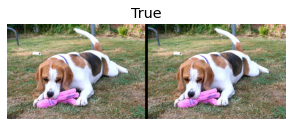

In [129]:
s.show()


In [130]:
img1 = PILImage.create(files[1])

<AxesSubplot:title={'center':'False'}>

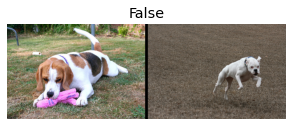

In [131]:
s = SiameseImage(img,img1,False)
s.show()

The transforms work on tuples(input,label) -> so the base class here is fastuple, a kind of tuple which makes it easier to work 

In [134]:
s2 = Resize(224)(s) # REsize is also a transform function  - works on tuples

<AxesSubplot:title={'center':'False'}>

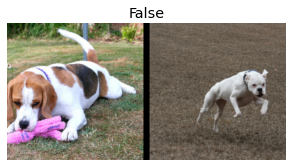

In [133]:
s2.show()

The class for creating dls for use in neural network is going to be constructed with all transformations on the inputs

In [136]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]
#using regex to take the label name from the name of the file

In [137]:
class SiameseImageTransform(Transform):
    def __init__(self,files,label_func,splits):
        self.labels = files.map(label_func).unique()
        self.label_func = label_func
        self.lbl2files = {l:L(f for f in files if label_func(f) == l) for l in self.labels} # to get files corresponding to labe
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same
        
    

For a file f, draw function will pick the same file with probability 50 percent, so it could have same or other files.

<AxesSubplot:title={'center':'True'}>

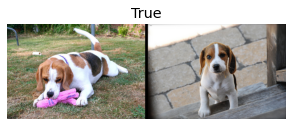

In [144]:
splits = RandomSplitter()(files)
tfm = SiameseImageTransform(files,label_func,splits)
tfm(files[0]).show()


<AxesSubplot:title={'center':'True'}>

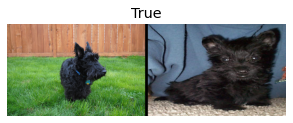

In [147]:
tfm(files[3]).show()


The SiameseImageTransform already return the tuples required (image1, image2, label)
so no parallel pipelines required -> TfmdLists is enough to apply the transforms

In [148]:
tls = TfmdLists(files, tfm, splits=splits)

In [149]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

# the dataloaders method converts the dataset into batches appropriate for neural networks- item_tfms and batch_tfms are syntacticak sugars provided by fastau
#here it is after_item (before batch processing), after_batch (after batch is constructed)
# ToTensor converts image to tensor
# InttoFloatTensor converts 0-255 to float based on mean and stddev
